# <a id='toc1_'></a>[Проект: Расчёт юнит экономики привлечения клиентов из разных каналов](#toc0_)

## <a id='toc1_1_'></a>[Описание](#toc0_)
Данные о LTV пользователей и стоимости привлечения находятся в файлах `customers.csv` и `cost_attraction.csv`. Перед выполнением расчётов необходимо произвести обзор данных. В предобработке данных будет произведена проверка на наличие ошибок в данных и при их наличии оценка их влияния на расчёты. После этого будут осуществлены расчёты и формирование бизнес выводов.

## <a id='toc1_2_'></a>[Цель](#toc0_)
Произвести расчёты эффективности вложения средств в разные каналы привлечения клиентов.

## <a id='toc1_3_'></a>[Вопросы](#toc0_)
1. Определить какие каналы окупаются
2. Определить какой из каналов самый прибыльный с точки зрения прибыли на один юнит
3. Сформулировать бизнес выводы на основании данных расчётов

**Содержание:**<a id='toc0_'></a>    
- [Проект: Расчёт юнит экономики привлечения клиентов из разных каналов](#toc1_)    
  - [Описание](#toc1_1_)    
  - [Цель](#toc1_2_)    
  - [Вопросы](#toc1_3_)    
- [Обзор данных](#toc2_)    
- [Предобработка данных](#toc3_)    
- [Расчёты](#toc4_)    
- [Вывод](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Импорт библиотек:

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <a id='toc2_'></a>[Обзор данных](#toc0_)

Чтение данных:

In [49]:
# данные по LTV пользователей
customers = pd.read_csv('data/customers.csv', sep =';')

# данные по затратам на привлечение в каждом канале
cost_attr = pd.read_csv('data/cost_attraction.csv', sep =';')

# функция для диагностики df
def df_diagnostics(df1):
    # основные характеристики
    diag = pd.DataFrame({
        'dtypes': df1.dtypes,
        'count': df1.count(),
        'unique': df1.nunique(),
        'nan_count': df1.isnull().sum(),
        'nan_%': df1.isnull().sum() / df1.shape[0] * 100})

    metrics = {
        'mean': lambda s: s.mean(),
        'median': lambda s: s.median(),
        'min': lambda s: s.min(),
        'max': lambda s: s.max()}

    # метрики только для числовых столбцов
    numeric_cols = df1.select_dtypes(include=[np.number]).columns
    for metric, func in metrics.items():
        diag[metric] = [func(df1[col]) if col in numeric_cols else np.nan
                        for col in df1.columns]

    # количество дублирующих строк в df
    duplicates_count = df1.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count)

    # df с градиентной подсветкой, форматированием и округлением чисел
    return (diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)
            .format("{:.2f}", subset=diag.select_dtypes(include=[np.number]).columns))

Обзор данных по пользователям из таблицы `customers.csv`

In [50]:
customers.head()

,id клиента,Канал привлечения,"LTV, руб."
0,1,Реклама у блогеров,350
1,2,Реклама у блогеров,205
2,3,Реклама у блогеров,252
3,4,Таргетная реклама,531
4,5,Реклама у блогеров,325


Обзор данных по стоимости привлечения в каналах из таблицы `cost_attraction.csv`

In [51]:
cost_attr

,Канал привлечения,"Стоимость привлечения, руб."
0,Таргетная реклама,100000
1,e-mail рассылки,25000
2,Реклама у блогеров,120000
3,Контекстная реклама,90000
4,Нативная реклама,70000
5,Реклама в новостных СМИ,60000


Диагностика данных:


In [52]:
# диагностика df с пользователями
df_diagnostics(customers)

Количество дублирующих строк: 0


,dtypes,count,unique,nan_count,nan_%,mean,median,min,max
id клиента,int64,1801.00,1801.00,0.00,0.00,901.00,901.00,1.00,1801.00
Канал привлечения,object,1801.00,6.00,0.00,0.00,nan,nan,nan,nan
"LTV, руб.",int64,1801.00,594.00,0.00,0.00,274.23,313.00,-100000.00,802.00


Диагностика таблицы `customers.csv` показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответствуют
- строк 1801
- клиенты по полю id `клиента` все уникальные
- 6 уникальных каналов привлечения клиентов
- пропусков нет
- в поле `LTV, руб.` минимальное значение -100000, ошибка данных, удалим его

In [53]:
# диагностика df со стоимостью привлечения
df_diagnostics(cost_attr)

Количество дублирующих строк: 0


,dtypes,count,unique,nan_count,nan_%,mean,median,min,max
Канал привлечения,object,6.00,6.00,0.00,0.00,nan,nan,nan,nan
"Стоимость привлечения, руб.",int64,6.00,6.00,0.00,0.00,77500.00,80000.00,25000.00,120000.00


Диагностика таблицы `cost_attraction.csv` показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответствуют
- строк 6
- пропусков нет
- числовые значения в поле `Стоимость привлечения, руб.` корректны

# <a id='toc3_'></a>[Предобработка данных](#toc0_)

В столбце `LTV, руб.` минимальное значение равно `-100000` - это ошибка в данных, удалим данную строку. После этого повторно выведем диагностику df.

In [54]:
# повторно сохраним в df все строки, кроме строки с ошибочным значением
customers = customers[customers['LTV, руб.'] != -100000]

# повторная диагностика df
df_diagnostics(customers)

Количество дублирующих строк: 0


,dtypes,count,unique,nan_count,nan_%,mean,median,min,max
id клиента,int64,1800.00,1800.00,0.00,0.00,900.50,900.50,1.00,1800.00
Канал привлечения,object,1800.00,6.00,0.00,0.00,nan,nan,nan,nan
"LTV, руб.",int64,1800.00,593.00,0.00,0.00,329.94,313.00,70.00,802.00


Выведем уникальные названия каналов

In [55]:
# уникальные значения в поле
customers['Канал привлечения'].unique()

array(['Реклама у блогеров', 'Таргетная реклама', 'e-mail рассылки',
       'Контекстная реклама', 'Реклама в новостных СМИ',
       'Нативная реклама'], dtype=object)

`Вывод:` во время предобработки данных выполнено удаление ошибочного наблюдения в поле 'LTV, руб.' со значением -100000.

# <a id='toc4_'></a>[Расчёты](#toc0_)

Построим график распределения LTV пользователей по каналам привлечения с целью увидеть из каких каналов пользователи в среднем приносят больше или меньше LTV.

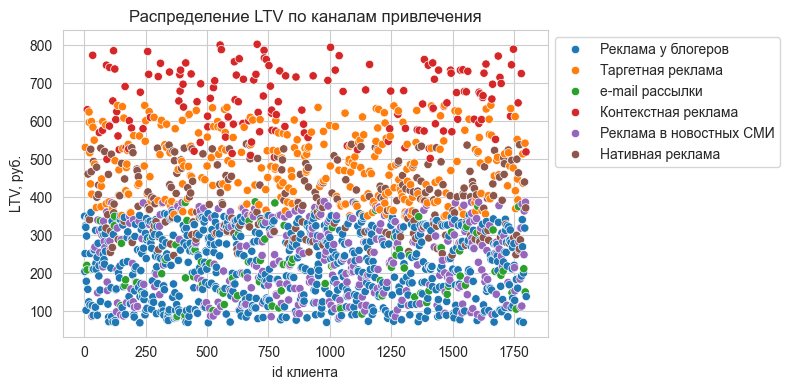

In [56]:
plt.figure(figsize=(8, 4))
sns.scatterplot(data=customers, x='id клиента', y='LTV, руб.', hue='Канал привлечения')
plt.title('Распределение LTV по каналам привлечения')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left') # легенду за график
plt.tight_layout()

Построим графики скрипичных ключей для наглядного сравнения медианных значений прибыли по каналам:

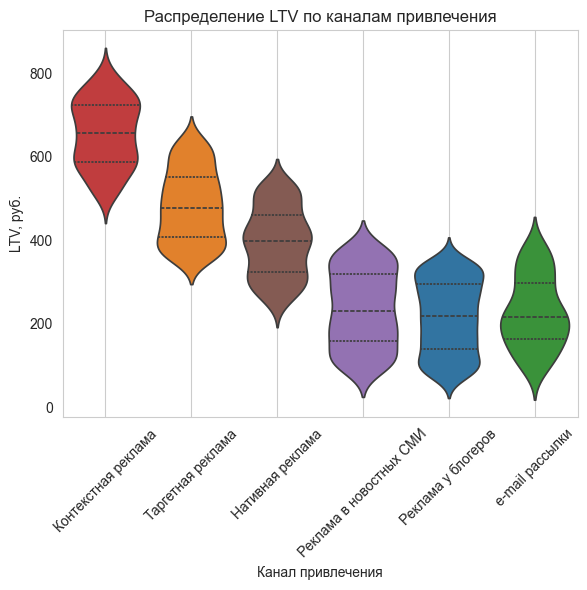

In [57]:
# Сортируем категории по медиане
x_column = 'Канал привлечения'
y_column = 'LTV, руб.'
order = (customers.groupby(x_column)[y_column]
         .median()
         .sort_values(ascending=False).index)

plt.figure(figsize=(6, 6))
sns.violinplot(data=customers, x=x_column, y=y_column,
               hue=x_column, order=order, inner='quartile')
plt.title('Распределение LTV по каналам привлечения')
plt.xticks(rotation=45)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.grid()
plt.tight_layout()

`Вывод:` Из представленного графика мы видим, что например чётко прослеживается то, что каналы `Контекстная реклама` и `Таргетная реклама` приводят клиентов, у которых LTV в среднем выше, а например канал `Реклама у блогеров` приводит клиентов с меньшим LTV.

В сводную таблицу добавим два новых столбца:
1. Средний LTV на канал в руб.;
2. Кол-во клиентов, пришедших из канала.

In [58]:
# создаём сводную таблицу
df_agg = (customers.groupby('Канал привлечения')
          .agg(
               mean = ('LTV, руб.', lambda x: round(x.mean(), 0)),
               count = ('LTV, руб.', 'count'))
          .reset_index())

# переименовываем названия столбцов
df_agg.rename(columns={'mean': 'Средний LTV, руб.', 'count': 'Кол-во клиентов'}, inplace=True)
df_agg

,Канал привлечения,"Средний LTV, руб.",Кол-во клиентов
0,e-mail рассылки,229.0,96
1,Контекстная реклама,656.0,154
2,Нативная реклама,395.0,255
3,Реклама в новостных СМИ,236.0,312
4,Реклама у блогеров,217.0,671
5,Таргетная реклама,483.0,312


Объединим таблицу затрат и сводную таблицу с целью увидеть общую картину.

In [59]:
# соединяем таблицы по полю `Канал привлечения`
df_group = pd.merge(cost_attr, df_agg, on='Канал привлечения', how='inner')
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов
0,Таргетная реклама,100000,483.0,312
1,e-mail рассылки,25000,229.0,96
2,Реклама у блогеров,120000,217.0,671
3,Контекстная реклама,90000,656.0,154
4,Нативная реклама,70000,395.0,255
5,Реклама в новостных СМИ,60000,236.0,312


Рассчитаем метрику CAC для каждого канала привлечения с целью узнать сколько приходится затрат в среднем на одного пользователя.

In [60]:
# добавляем новый столбец как результат деления полей `Стоимость привлечения, руб.` на `Кол-во клиентов` с округлением
df_group = df_group.assign(cac = round(df_group['Стоимость привлечения, руб.'] / df_group['Кол-во клиентов'], 1))
df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов,cac
0,Таргетная реклама,100000,483.0,312,320.5
1,e-mail рассылки,25000,229.0,96,260.4
2,Реклама у блогеров,120000,217.0,671,178.8
3,Контекстная реклама,90000,656.0,154,584.4
4,Нативная реклама,70000,395.0,255,274.5
5,Реклама в новостных СМИ,60000,236.0,312,192.3


Рассчитаем для каждого канала среднюю прибыль на 1 пользователя через вычитание из среднего LTV и средних затрат на одного пользователя.

In [61]:
# добавляем новый столбец как результат деления полей `Стоимость привлечения, руб.` на `Кол-во клиентов`
df_group = df_group.assign(ltv_cac = round(df_group['Средний LTV, руб.'] - df_group['cac'], 1))

# переименовываем названия столбцов
df_group.rename(columns={'cac': 'CAC, руб.', 'ltv_cac': 'Прибыль на 1 юнит, руб.'}, inplace=True)

# Сортируем категории по медиане LTV
df_group = df_group.sort_values('Прибыль на 1 юнит, руб.', ascending=False)

df_group

,Канал привлечения,"Стоимость привлечения, руб.","Средний LTV, руб.",Кол-во клиентов,"CAC, руб.","Прибыль на 1 юнит, руб."
0,Таргетная реклама,100000,483.0,312,320.5,162.5
4,Нативная реклама,70000,395.0,255,274.5,120.5
3,Контекстная реклама,90000,656.0,154,584.4,71.6
5,Реклама в новостных СМИ,60000,236.0,312,192.3,43.7
2,Реклама у блогеров,120000,217.0,671,178.8,38.2
1,e-mail рассылки,25000,229.0,96,260.4,-31.4


Для наглядности построим график и покажем на нём для каждого канала привлечения среднюю прибыль на одного пользователя.

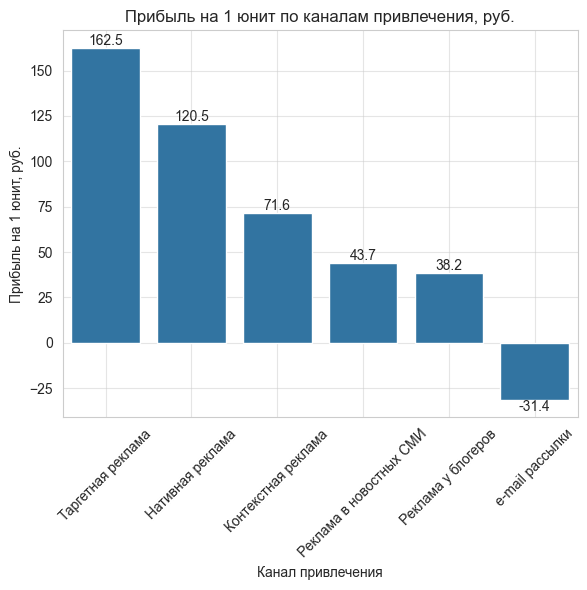

In [62]:
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=df_group, x='Канал привлечения', y='Прибыль на 1 юнит, руб.')
ax.bar_label(ax.containers[0])
plt.title('Прибыль на 1 юнит по каналам привлечения, руб.')
plt.xticks(rotation=45)
plt.xlabel('Канал привлечения')
plt.ylabel('Прибыль на 1 юнит, руб.')
plt.grid(alpha=0.5)
plt.tight_layout()

`Вывод:`
- Окупаются все каналы, кроме 'e-mail рассылки'.
- Самым прибыльным каналом является 'Таргетная реклама'.
- Канал 'e-mail рассылки' приносит убытки и по этому, если у него нет прогнозов, что вскоре через этот канал будет приходить более платежеспособный клиент, то от него стоит отказаться. Канал 'Таргетная реклама' самый выгодный с точки зрения прибыли на 1 клиента, поэтому инвестиции в него стоит увеличивать.

---
# <a id='toc5_'></a>[Вывод](#toc0_)

`Предобработка данных:` выполнено удаление ошибочного наблюдения в поле 'LTV, руб.' со значением -100000.

`Какие каналы окупаются?` Окупаются все каналы, кроме 'e-mail рассылки'.

`Какой из каналов самый прибыльный на один юнит?` Самым прибыльным каналом является 'Таргетная реклама'.

`Бизнес выводы:` Канал 'e-mail рассылки' приносит убытки и по этому, если у него нет прогнозов, что вскоре через этот канал будет приходить более платежеспособный клиент, то от него стоит отказаться. Канал 'Таргетная реклама' самый выгодный с точки зрения прибыли на 1 клиента, поэтому инвестиции в него стоит увеличивать.